In [78]:
from pandas import read_csv, Series
from gensim.models import Word2Vec, KeyedVectors
import numpy as np
from pickle import load
from glove import Glove

In [3]:
from pymorphy2 import MorphAnalyzer
from nltk.tokenize import RegexpTokenizer
morph = MorphAnalyzer()
alpha_tokenizer = RegexpTokenizer('[A-Za-zА-Яа-я]\w+')

In [4]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.dummy import DummyClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import (accuracy_score, brier_score_loss, precision_score, recall_score, f1_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

In [5]:
import matplotlib.pyplot as plt
import seaborn

Вспомогательные функции для работы с Glove-моделью

In [10]:
def cosine_sim(word1, word2):
    return 1 - spatial.distance.cosine(wv(word1), wv(word2))

def wv(word):
    return glove.word_vectors[glove.dictionary[word]]

In [57]:
old_err_state = np.seterr(all='raise')

def vectorize_message(sentence, model, num_features, vocab):
    featureVec = np.zeros((num_features), dtype='float32')
    nwords = 0
    
    tokens = pre_process(sentence.lower(), vocab)

    for word in tokens:
        if word in vocab: 
            if model == 'word2vec':
                featureVec = np.add(featureVec, word2vec[word])
            elif model == 'wang2vec':
                featureVec = np.add(featureVec, model[word])
            elif model == 'glove':
                featureVec = np.add(featureVec, wv(word))
            elif model == 'word2vecf':
                featureVec = np.add(featureVec, model[word])
            nwords = nwords + 1
    try:
        featureVec = np.divide(featureVec, nwords)
    except FloatingPointError:
         featureVec = np.zeros((num_features), dtype='float32')
    return featureVec

In [20]:
def pre_process(sentence, vocab):
    sentence = sentence.lower()
    tokens = alpha_tokenizer.tokenize(sentence)
    model_tokens = []
    for index, word in enumerate(tokens):
        lem_word = morph.parse(word.lower())[0].normal_form
        if lem_word in vocab:
            model_tokens.append(lem_word)
    return model_tokens

In [6]:
df = read_csv('2ch_test_set.csv')
df.head()

,index,text,is_relevent
0,0,ПХП умерло в 2013 году. Если свой сайт сделаю ...,1
1,1,"PHP это ковырялки легаси, плохая производитель...",1
2,2,"Не позорь go сообщество, чушь несешь.",1
3,3,После установки git появились git cmd и git ba...,1
4,4,даров где можно скачать какие нибудь паки карт...,0


In [7]:
Y = df.is_relevent.values

Загрузка Word2Vec-модели

In [8]:
word2vec = Word2Vec.load('models/2ch_word2vec')
word2vec_vocab = word2vec.wv.vocab

Загрузка Glove-модели

In [14]:
with open('models/glove_2ch', 'rb') as fp:
    glove = load(fp)

In [19]:
glove_vocab = glove.dictionary

Загрузка Wang2Vec-модели

In [79]:
wang2vec = KeyedVectors.load_word2vec_format('models/wang2vec_2ch', binary=True)
wang2vec_vocab = wang2vec.vocab

Получение датасетов

In [53]:
word2vec_vectors = np.zeros(shape=(len(df),100), dtype='float32')

for i, m in df.iterrows():
    word2vec_vectors[i] = vectorize_message(m['text'], 'word2vec', 100, word2vec_vocab)

In [58]:
glove_vectors = np.zeros(shape=(len(df),100), dtype='float32')

for i, m in df.iterrows():
    glove_vectors[i] = vectorize_message(m['text'], 'glove', 100, glove_vocab)

In [80]:
wang2vec_vectors = np.zeros(shape=(len(df),100), dtype='float32')

for i, m in df.iterrows():
    wang2vec_vectors[i] = vectorize_message(m['text'], 'wang2vec', 100, wang2vec_vectors)

/home/defeater/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


Сравнение

In [92]:
def set_plt_params():
    title_font = {'fontname':'Arial', 'size':'30', 'color':'black', 'weight':'normal',
                  'verticalalignment':'bottom'} 
    axis_font = {'fontname':'Arial', 'size':'30'}

    plt.figure(figsize=(40, 20))
    plt.title('Classifiers Evaluation', **title_font)
    plt.xlabel('Training examples', **axis_font)
    plt.ylabel('Score',  **axis_font)
    plt.tick_params(labelsize=30)

/home/defeater/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


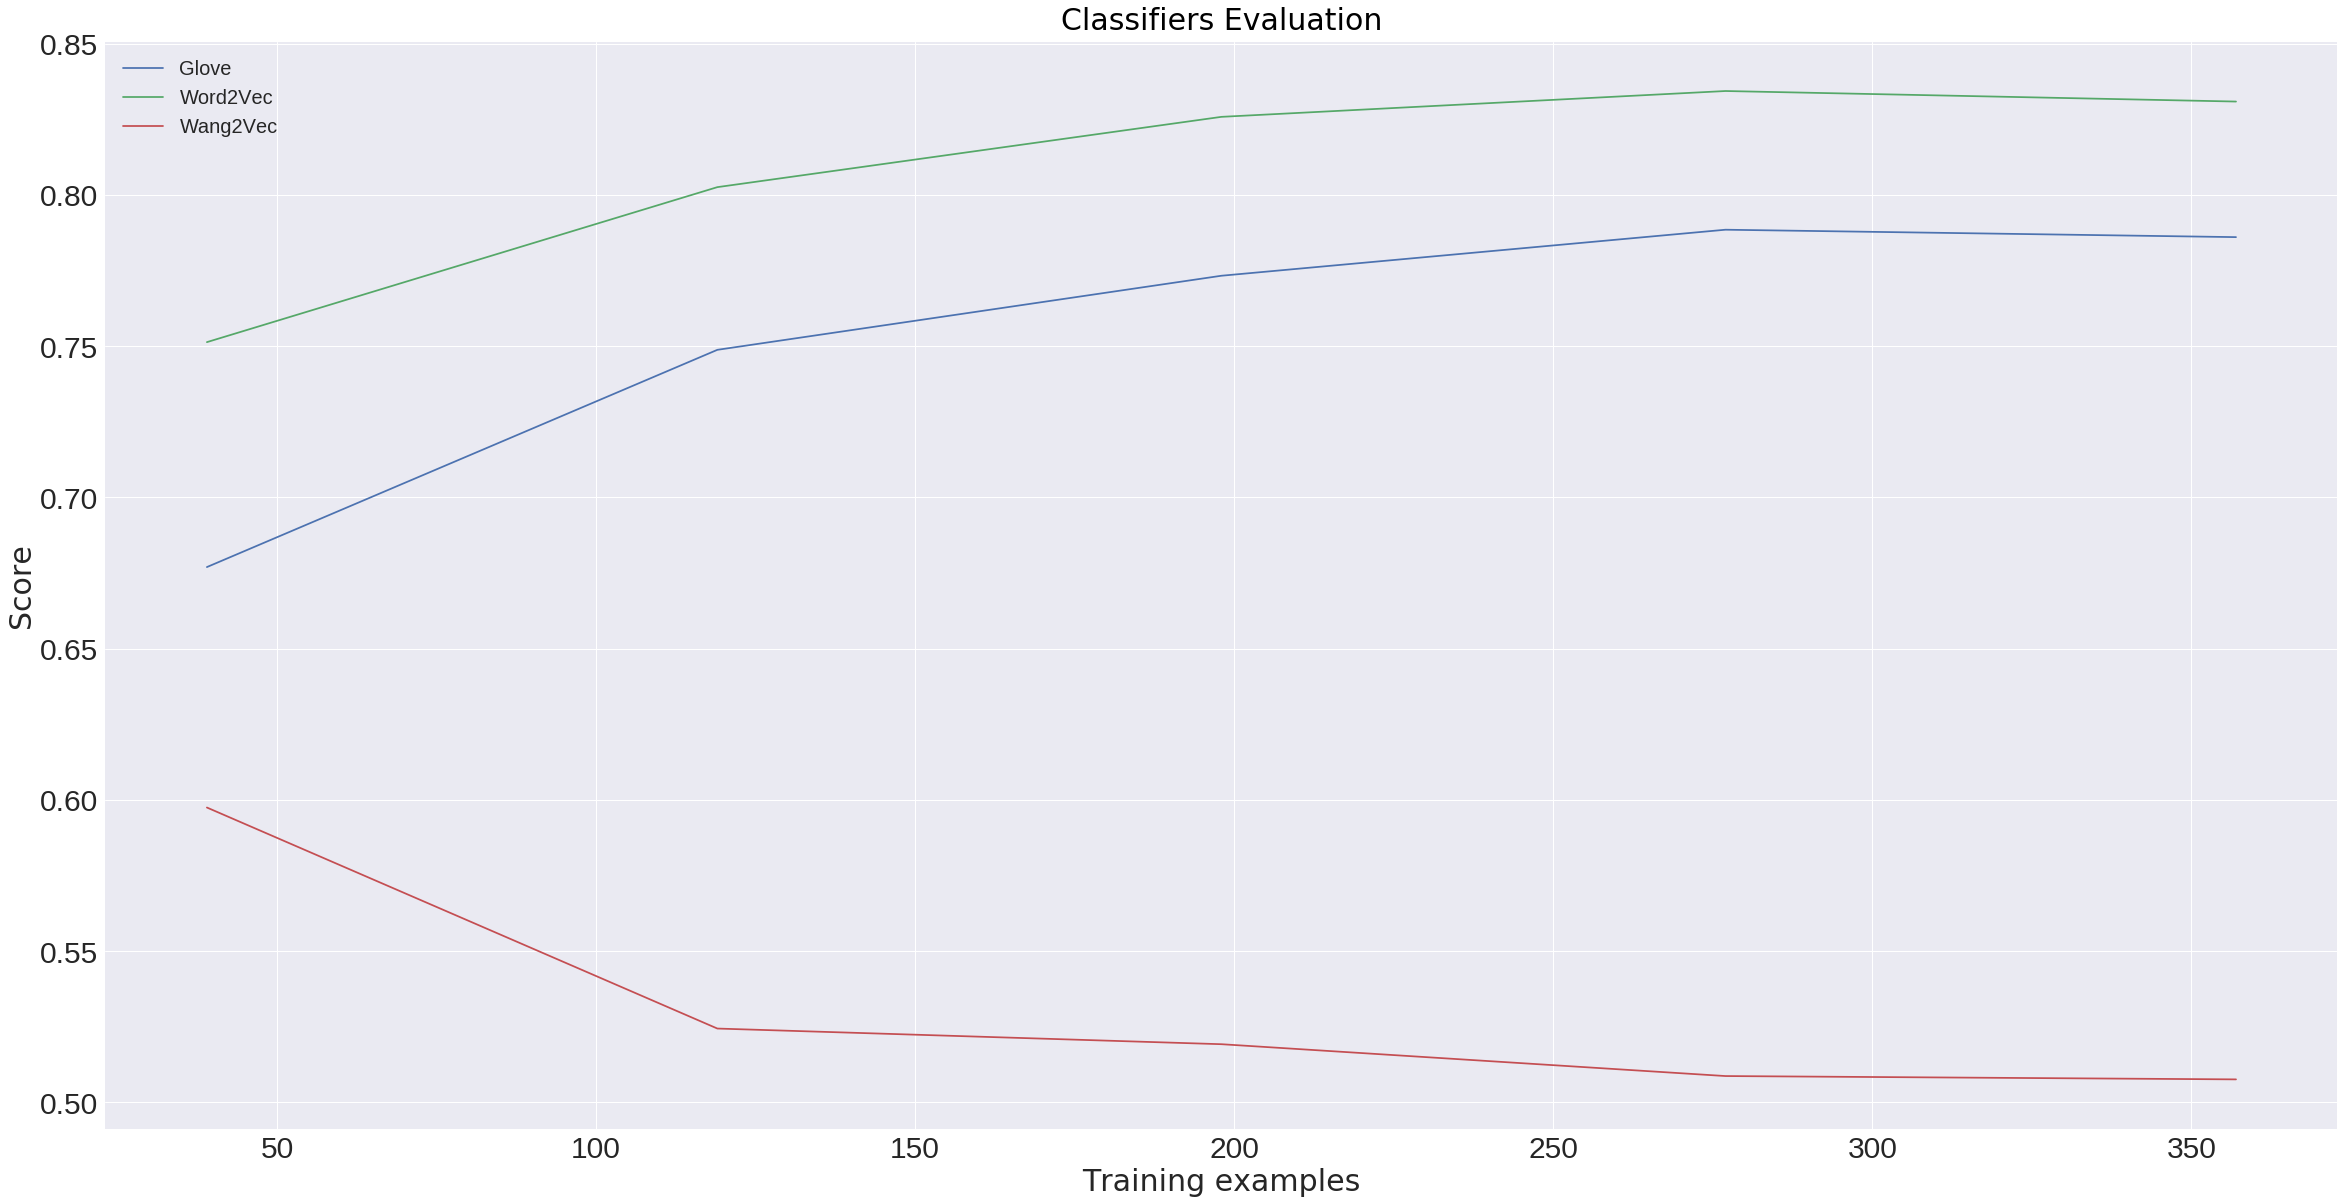

In [96]:
set_plt_params()

for X, name in [(glove_vectors, 'Glove'),
                (word2vec_vectors, 'Word2Vec'),
                (wang2vec_vectors, 'Wang2Vec'),
                ]:
    #estimator = SVC(C = 0.01, kernel = 'linear')
    estimator = KNeighborsClassifier(n_neighbors = 7)
    cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=0)
    train_sizes=np.linspace(0.1, 0.9, 5)
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, Y, cv=cv, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.plot(train_sizes, train_scores_mean, label=name)
    plt.legend(loc='best')

    #plt.savefig('classifiers.png', bbox_inches='tight')
plt.show()